In [1]:
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms

import torch
from torch import nn
from torch.nn import functional as F
from torchmetrics import Accuracy

import numpy as np

from resnet import resnet18

from weight_drop import *

import math

In [2]:
n_labeled = 16384

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, ), (0.5, ))])
# dataset_train = datasets.MNIST(root = "../data", transform = transform, train = True, download = True)
# dataset_train = torch.utils.data.Subset(dataset_train, np.random.choice(len(dataset_train), size = (n_labeled,)))
# dataset_test = datasets.MNIST(root = "../data", transform = transform, train = False, download = True)

# input_ch = 1
# dataset_name = "MNIST"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

dataset_train = datasets.CIFAR10(root = "../data", transform = transform, train = True, download = True)
dataset_train = torch.utils.data.Subset(dataset_train, np.random.choice(len(dataset_train), size = (n_labeled,)))
dataset_test = datasets.CIFAR10(root = "../data", transform = transform, train = False, download = True)

input_ch = 3
image_size = 32
dataset_name = "CIFAR10"

Files already downloaded and verified
Files already downloaded and verified


In [3]:
from tqdm import tqdm

n_trials = 6
batch_size = 1024

train_dl = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)

test_dl = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)

is_uncertain = False
def get_uncertain():
    return is_uncertain
#     return True

class Network(nn.Module):
    
    def __init__(self, hidden_dim = 4096):
        
        super().__init__()

        self.hidden_dim = hidden_dim
        self.nfc = 0
        
        p = 0.98
        
######################################################
        self.net = torch.nn.Sequential(
            resnet18(
                num_classes = self.hidden_dim,
                zero_init_residual = False,
                conv1_type = "cifar",
                no_maxpool = True,
                width_per_group = 64,
                norm_layer = nn.InstanceNorm2d,
#                 norm_layer = nn.Identity,
                input_ch = input_ch,
                get_uncertain = get_uncertain,
                p = p
            ),
            torch.nn.ReLU(),
        )
        
#         self.model_type = "ResNet18-noNorm"
        self.model_type = "ResNet18-IN-2x-drop%3d" % (p * 100)
        
######################################################
#         self.net = torch.nn.Sequential(
#             torch.nn.Flatten(),
#             torch.nn.Linear(
#                 image_size * image_size * input_ch,
#                 self.hidden_dim),
#             torch.nn.BatchNorm1d(self.hidden_dim),
#             torch.nn.ReLU(),
# #             torch.nn.Dropout(),
#         )
        
#         self.model_type = "Shallow-BN"

######################################################
#         norm_layer = torch.nn.BatchNorm1d
#         # norm_layer = torch.nn.Identity
#         self.net = torch.nn.Sequential(
#             torch.nn.Flatten(),
#             torch.nn.Linear(
#                 image_size * image_size * input_ch,
#                 self.hidden_dim),
#             norm_layer(self.hidden_dim, affine = False),
#             torch.nn.ReLU(),
#             self.WrappedLinear(self.hidden_dim, self.hidden_dim),
#             norm_layer(self.hidden_dim, affine = False),
#             torch.nn.ReLU(),
# #             self.WrappedLinear(self.hidden_dim, self.hidden_dim),
# #             norm_layer(self.hidden_dim, affine = False),
# #             torch.nn.ReLU(),
# #             self.WrappedLinear(self.hidden_dim, self.hidden_dim),
# #             norm_layer(self.hidden_dim, affine = False),
# #             torch.nn.ReLU(),
# #             torch.nn.Dropout(),
#         )
        
#         self.model_type = "3-layer MLP (BN-noAffine) "

######################################################
#         norm_layer = torch.nn.LayerNorm
#         norm_layer = torch.nn.InstanceNorm2d
#         norm_layer = torch.nn.Identity
#         nd = self.hidden_dim // 16
#         self.net = torch.nn.Sequential(
#             *self.WrappedConvolutionalBlock(32, 32, 3, nd // 4, kernel = 5, norm = norm_layer, p = 1), # 32x32
#             *self.WrappedConvolutionalBlock(32, 32, nd // 4, nd // 2, kernel = 3, stride = 2, norm = norm_layer, p = p), # 16x16
#             *self.WrappedConvolutionalBlock(16, 16, nd // 2, nd // 2, kernel = 3, norm = norm_layer, p = p), # 16x16
#             *self.WrappedConvolutionalBlock(16, 16, nd // 2, nd, kernel = 3, stride = 2, norm = norm_layer, p = p), # 8x8
#             *self.WrappedConvolutionalBlock( 8,  8, nd, nd, kernel = 3, norm = norm_layer, p = p), # 8x8
#             *self.WrappedConvolutionalBlock( 8,  8, nd, nd, kernel = 3, stride = 2, norm = norm_layer, p = p), # 4x4
#             *self.WrappedConvolutionalBlock( 4,  4, nd, nd, kernel = 3, norm = norm_layer, p = p), # 4x4
#             torch.nn.Flatten(),
#         )
        
#         self.model_type = "7-layer-CNN-IN-%f" % p

        self.head = torch.nn.Sequential(
            torch.nn.Linear(self.hidden_dim, 10)
        )
    
    def WrappedLinear(self, in_ch, out_ch, p = 0.5):
        layer = torch.nn.Linear(in_ch, out_ch)
#         self.nfc += 1
#         self.add_module("fc%d" % self.nfc, layer)
        return WeightDrop(layer, ['weight'], p, get_uncertain)

    def calc_same_pad(self, i: int, k: int, s: int, d: int) -> int:
        return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)

    def WrappedConvolutionalBlock(self, h, w, in_ch, out_ch, norm = torch.nn.InstanceNorm2d,\
                                  kernel = 3, stride = 1, act = True, p = 0.5):
        
        conv = nn.Conv2d(in_ch, out_ch, kernel, stride = stride, 
                         padding = math.ceil(self.calc_same_pad(64, kernel, stride, 1) / 2))
        if p < 1:
            conv = WeightDrop(conv, ['weight'], p, get_uncertain)
        
        if norm is torch.nn.LayerNorm:
            bn = norm([out_ch, h // stride, w // stride])
        else:
            bn = norm(out_ch)
        
        if act:
            return [conv, bn, nn.ReLU(inplace = True)]
        else:
            return [conv, bn]

    def forward(self, x):
        return self.head(self.net(x))

device = torch.device('cuda:0')
lossFn = nn.CrossEntropyLoss()
accFn  = Accuracy()

trial_logits = []

for i in range(n_trials):
    
    print("Trial %d" % (i + 1))
    
    hidden_dim = 1024
    net = Network(hidden_dim)
    
    optim = torch.optim.AdamW(net.parameters())
    
    net = net.to(device)
    net.train()
    
#     print(net)
#     print(list(net.modules()))
    
    epochs = 100
    for ep in tqdm(range(epochs)):
        for batch in train_dl:
            
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            
#             print(y)
            
            output = net(x)
            loss = lossFn(output, y)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
    
    # Obtain results
    net.eval()
    accuracy = 0
    cnt = 0
    logits = []
    for batch in test_dl:
        x, y = batch
        x = x.to(device)
        
        output = net(x)
        logits.append(output.detach().cpu())
        
        preds = torch.argmax(output, dim=1)
        accuracy += accFn(preds.detach().cpu(), y)
        
        cnt += 1
        
    logits = torch.cat(logits, dim = 0)
    trial_logits.append(logits)
    
    accuracy /= cnt
    print("Final accuracy: %.2f" % (accuracy * 100.0))

Trial 1
conv1_type:cifar
no_maxpool:True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [14:54<00:00,  8.95s/it]


Final accuracy: 67.17
Trial 2
conv1_type:cifar
no_maxpool:True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [14:55<00:00,  8.95s/it]


Final accuracy: 65.79
Trial 3
conv1_type:cifar
no_maxpool:True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [14:57<00:00,  8.97s/it]


Final accuracy: 66.57
Trial 4
conv1_type:cifar
no_maxpool:True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:12<00:00,  9.12s/it]


Final accuracy: 66.39
Trial 5
conv1_type:cifar
no_maxpool:True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:02<00:00,  9.03s/it]


Final accuracy: 66.48
Trial 6
conv1_type:cifar
no_maxpool:True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:01<00:00,  9.01s/it]


Final accuracy: 67.51


In [4]:
# Results with activations
net.eval()
is_uncertain = True

# for l in [1, 3, 5, 7]:
#     if 'weight' in net.net[l].module._parameters:
#         del net.net[l].module._parameters['weight']
# print(net.net[1].module._parameters)

activation = []
for batch in test_dl:
    x, y = batch
    x = x.to(device)

    z = net.net(x)
    out = (z.unsqueeze(1) * net.head[0].weight.unsqueeze(0)).squeeze().detach().cpu()
    
    activation.append(out)

activation = torch.cat(activation)
print(activation.shape)
activation_std = activation.std(2)
print(activation_std.shape)

is_uncertain = False

torch.Size([10000, 10, 1024])
torch.Size([10000, 10])


In [5]:
nza_count = (activation != 0).sum(2, keepdims = True)
nza_mean = activation.sum(2, keepdims = True) / nza_count
nza_var = (((activation - nza_mean) * (activation != 0)) ** 2).sum(2) / (nza_count.squeeze() - 1)
nza_std = torch.sqrt(nza_var)
print(nza_std.shape)
print(nza_std)
# nza_mean = 

torch.Size([10000, 10])
tensor([[0.1467, 0.1537, 0.1488,  ..., 0.1487, 0.1384, 0.1334],
        [0.1419, 0.1490, 0.1450,  ..., 0.1453, 0.1358, 0.1305],
        [0.1455, 0.1524, 0.1443,  ..., 0.1446, 0.1364, 0.1323],
        ...,
        [0.1419, 0.1410, 0.1459,  ..., 0.1240, 0.1385, 0.1393],
        [0.1433, 0.1423, 0.1476,  ..., 0.1244, 0.1383, 0.1389],
        [0.1430, 0.1410, 0.1466,  ..., 0.1262, 0.1375, 0.1405]])


In [6]:
torch.save(trial_logits, "%dtrial_logits_%s(%d)_%s-%d.pkl" % (n_trials, dataset_name, n_labeled, net.model_type, net.hidden_dim))
torch.save(activation, "%dacts_logits_%s(%d)_%s-%d.pkl" % (n_trials, dataset_name, n_labeled, net.model_type, net.hidden_dim))

In [7]:
trial_logits_t = torch.stack(trial_logits, dim = 0)
trial_std = trial_logits_t.std(dim = 0)
print(trial_std.shape)

torch.Size([10000, 10])


In [8]:
# print(dataset_test.targets)

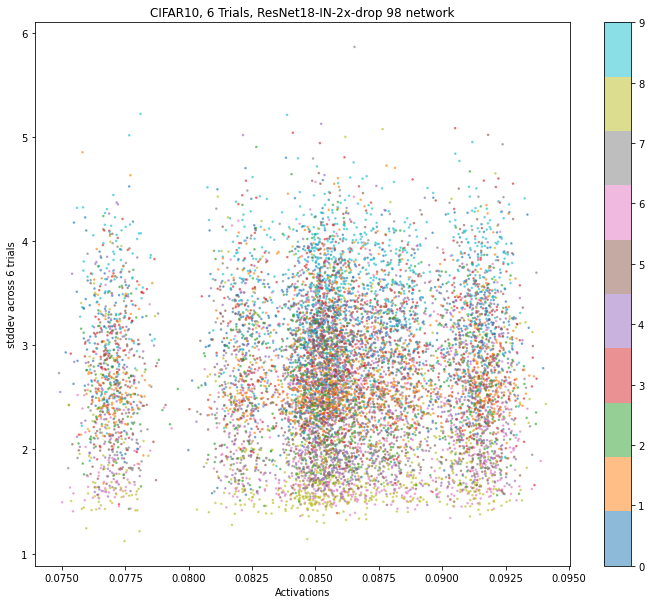

In [9]:
from matplotlib import pyplot as plt
plt.figure(figsize = (12, 10))

colorbar = plt.scatter(
#     nza_std.mean(dim = 1), trial_std.mean(dim = 1), alpha = 0.5, marker = '.',
    activation_std.mean(dim = 1), trial_std.mean(dim = 1), alpha = 0.5, marker = '.',
    s = 10, c = dataset_test.targets, cmap = "tab10")
plt.colorbar(colorbar)
plt.xlabel("Activations")
plt.ylabel("stddev across %d trials" % (n_trials))
plt.title("%s, %d Trials, %s network" % (dataset_name, n_trials, net.model_type))

plt.savefig("%dtrials_%s(%d)_%s-%d.png" % (n_trials, dataset_name, n_labeled, net.model_type, net.hidden_dim))
plt.show()

#### 